In [1]:
%matplotlib inline
import random
random.seed(0)
import numpy as np
import warnings
warnings.simplefilter('ignore')
import pandas as pd
from sklearn.metrics.pairwise import pairwise_distances
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, roc_auc_score
# from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

import timeit
from sklearn.decomposition import FastICA as ICA
# from sklearn.random_projection import SparseRandomProjection as RCA
from sklearn.random_projection import GaussianRandomProjection as RCA
from sklearn.ensemble import RandomForestClassifier as RFC
from itertools import product
from collections import defaultdict
# from sklearn.metrics import  confusion_matrix
from sklearn.metrics import  adjusted_rand_score
from sklearn.cluster import KMeans 
from sklearn import metrics
from sklearn.decomposition import PCA,FastICA
from sklearn.decomposition import FactorAnalysis as FA

from sklearn.mixture import GaussianMixture as EM
from sklearn.metrics import silhouette_score as sil_score, homogeneity_score

In [2]:
def import_data():
    missing_values = ['?']
    df_ds1 = pd.read_csv("winequality-white.csv", sep=";",na_values = missing_values).append(pd.read_csv("winequality-red.csv", sep=";",na_values = missing_values), ignore_index=True)
    df_ds1.fillna(method='ffill',inplace=True)
#     df_ds1.replace(np.inf, 0, inplace=True)
    df_ds2 = pd.read_csv("breast-cancer-wisconsin.csv", sep=",",na_values = missing_values)
    df_ds2.fillna(method='ffill',inplace=True)
#     df_ds2.replace(np.inf, 0, inplace=True)
    X_ds1 = np.array(df_ds1.values[:,1:-1])
    y_ds1 = np.array(df_ds1.values[:,-1])
    y_ds1 = (y_ds1<6).astype(int)
    X_ds2 = np.array(df_ds2.values[:,1:-1])
    y_ds2 = np.array(df_ds2.values[:,-1])
    y_ds2 = (y_ds2<3).astype(int)
#     np.where(y_ds2==2,0,y_ds2)
#     np.where(y_ds2==4,1,y_ds2)
    return df_ds1, df_ds2, X_ds1, y_ds1, X_ds2, y_ds2

In [3]:
def process_data():
    df_Wine, df_BC, X_Wine, Y_Wine, X_BC, Y_BC = import_data()
    X_Wine = df_Wine.drop('quality', axis=1)
    Y_Wine = df_Wine.quality
#     print(df_BC.head(5))
    X_BC = df_BC.drop('Class', axis=1)
    Y_BC = df_BC.Class
    sc = StandardScaler()
    X_Wine = sc.fit_transform(X_Wine)
#     print(type(X_Wine))
    X_BC = sc.fit_transform(X_BC)
    return df_Wine, df_BC, X_Wine, Y_Wine, X_BC, Y_BC
    

In [4]:
def plot_cluster(y_values, x_values, plot_fmt, label_plot, title, xlabel, ylabel, filename, ticks = True, cumsum=False):
    if len(x_values) == 1:
        plt.plot(y_values, x_values[0], plot_fmt, label=label_plot[0])
    else:
        for i in range(0,len(x_values)):
            plt.plot(y_values, x_values[i], plot_fmt, label=label_plot[i])
#         plt.plot(y_values, x_values[0], plot_fmt, label=label_plot[0])
#         plt.plot(y_values, x_values[1], plot_fmt, label=label_plot[1])
    if ticks == True:
        plt.xticks(np.arange(min(y_values), max(y_values)+1, 2.0))
    plt.grid(True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if cumsum == True:
        plt.axhline(y=0.95, color='r', linestyle='--', dashes=(5, 5))
        plt.text(0.5, 0.90, '95% cut-off threshold',color = 'green', fontsize=12)
        plt.axhline(y=0.80, color='r', linestyle='--', dashes=(5, 5))
        plt.text(0.5, 0.75, '80% cut-off threshold',color = 'green', fontsize=12)
    plt.legend(loc="best")
    plt.grid()
#     plt.savefig(filename)
    plt.show()

In [5]:
def plot_hcv(k,score, title,filename):
    __scores = score
    __k = k
    plt.plot(__k, [s[0] for s in __scores], 'r', label='Homogeneity')
    plt.plot(__k, [s[1] for s in __scores], 'b', label='Completeness')
    plt.plot(__k, [s[2] for s in __scores], 'y', label='V-Measure')
    plt.xlabel('Value of K')
    plt.ylabel('homogeneity_completeness_v_measure')
    plt.title(title)
    plt.legend(loc='best')
#     plt.savefig(filename)
    plt.show()

In [6]:
def plot_rca(dims, mean_recon, std_recon, title, xlabel, ylabel, filename):

    fig, ax1 = plt.subplots()
    ax1.plot(dims,mean_recon, 'b-')
    ax1.set_xlabel(xlabel)
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel(ylabel[0], color='b')
    ax1.tick_params('y', colors='b')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(dims,std_recon, 'm-')
    ax2.set_ylabel(ylabel[1], color='m')
    ax2.tick_params('y', colors='m')
    plt.grid(False)

    plt.title(title)
    fig.tight_layout()
#     plt.savefig(filename)
    plt.show()

In [7]:
def plot_composition(reduced_data, Z_Value, kmeans, xx, yy, x_min, x_max, y_min, y_max, title, filename):
    plt.figure(1)
    plt.clf()
    plt.imshow(Z_Value, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title(title)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [8]:
def execute_K(K_list, X, y):
    inertia, sil_scores, homo_scores, ars = [], [], [], []
    homogeneity_completeness_v_measure = []
    for k in K_list:
        km = KMeans(n_clusters=k, init='k-means++',random_state=0)
        km = km.fit(X)
        inertia.append(km.inertia_)
        sil_scores.append(metrics.silhouette_score(X, km.labels_,metric='euclidean'))
        homo_scores.append(metrics.homogeneity_score(y, km.labels_))
        ars.append(metrics.adjusted_rand_score(y, km.labels_))
        homogeneity_completeness_v_measure.append(metrics.homogeneity_completeness_v_measure(y, km.labels_))
    return inertia, sil_scores, homo_scores, ars, homogeneity_completeness_v_measure

In [9]:
def execute_EM(n_components_list, X, y):
    bic_scores, aic_scores, ll = [], [], []
    for n in n_components_list:
        #start_time = timeit.default_timer()
        em = EM(n_components=n,covariance_type='diag',n_init=1,warm_start=True,random_state=100).fit(X)
        #end_time = timeit.default_timer()
        #train_times.append(end_time - start_time)
        
        labels = em.predict(X)
        aic_scores.append(em.aic(X))
        bic_scores.append(em.bic(X))
        ll.append(em.score(X))
    return bic_scores, aic_scores, ll
    

In [10]:
def execute_PCA(X,y,components=None,random_state=5):
    __X,__y = X,y
    __components,__random_state = components,  random_state
    if __components == None:
        pca = PCA(random_state=__random_state).fit(__X) #for all components
    else:
        pca = PCA(n_components=components, random_state=__random_state).fit(__X) #for all components
    cum_var = np.cumsum(pca.explained_variance_ratio_)
    return pca, cum_var

In [11]:
def execute_ICA(X,y):
    __X = X
    __y = y
    dims = list(np.arange(2,(X.shape[1]-1),3))
    dims.append(X.shape[1])
    ica = ICA(whiten=True,random_state=0)
    kurt = []

    for dim in dims:
        ica.set_params(n_components=dim)
        tmp = ica.fit_transform(__X)
        tmp = pd.DataFrame(tmp)
        tmp = tmp.kurt(axis=0)
        kurt.append(tmp.abs().mean())
    return dims, kurt

In [12]:
def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]
    
    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

In [13]:
def execute_RP(X,y, dim_range):
    __X,__y = X,y
    dims = list(np.arange(2,(X.shape[1]-1),3))
    dims.append(X.shape[1])
    tmp = defaultdict(dict)

    for i,dim in product(range(dim_range),dims):
        rp = RCA(random_state=i, n_components=dim)
        tmp[dim][i] = pairwiseDistCorr(rp.fit_transform(__X), __X)
    tmp = pd.DataFrame(tmp).T
    mean_recon = tmp.mean(axis=1).tolist()
    std_recon = tmp.std(axis=1).tolist()
    return dims, mean_recon, std_recon


In [14]:
def execute_RFC(X,y,df_original,n_estimators,random_state,n_jobs):
    __X,__y,__df_original,__n_estimators,__random_state,__n_jobs = X,y,df_original,n_estimators,random_state,n_jobs
    rfc = RFC(n_estimators=__n_estimators,min_samples_leaf=round(len(__X)*.01),random_state=__random_state,n_jobs=__n_jobs)
    imp = rfc.fit(__X,__y).feature_importances_ 
    imp = pd.DataFrame(imp,columns=['Feature Importance'],index=__df_original.columns)
    imp.sort_values(by=['Feature Importance'],inplace=True,ascending=False)
    imp['Cum Sum'] = imp['Feature Importance'].cumsum()
    imp = imp[imp['Cum Sum']<=0.87]
    top_cols = imp.index.tolist()
    return imp, top_cols

In [15]:
def pca_cluster(X,n_components,random_state):
    pca_cluster = PCA(n_components=n_components,random_state=random_state).fit_transform(X)
    return pca_cluster

In [16]:
def ica_cluster(X,n_components,random_state):
    ica_cluster = FastICA(n_components = n_components,whiten=True, random_state= random_state).fit_transform(X)
    return ica_cluster

In [17]:
def rca_cluster(X,n_components,random_state):
    rca_cluster = RCA(n_components = n_components, random_state= random_state).fit_transform(X)
    return rca_cluster

In [18]:
def rf_cluster(df_ds, column, top_cols):
    rf_cluster =  df_ds.drop(column, axis=1)[top_cols]
    return rf_cluster

In [19]:
def fa_cluster(X,n_components,random_state):
    fa_cluster = FactorAnalysis(n_components=n_components, random_state=random_state).fit_transform(X)
    return fa_cluster

In [20]:
def composition_analysis(reduced_data, X,Y, n_init, h=0.02,cluster=None):
    if cluster == None :
        n_clusters = len(np.unique(Y))
    else:
        n_clusters = cluster
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=n_init)
    kmeans.fit(reduced_data)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = h     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z_Value = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z_Value = Z_Value.reshape(xx.shape)
    return reduced_data, Z_Value, kmeans, xx, yy, x_min, x_max, y_min, y_max

# Data Load

In [21]:
seed = 0
np.random.seed(seed)
df_Wine, df_BC, X_Wine, Y_Wine, X_BC, Y_BC = process_data()

In [22]:
print(df_Wine.shape,df_BC.shape)

(6497, 12) (699, 11)


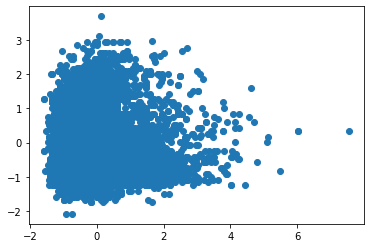

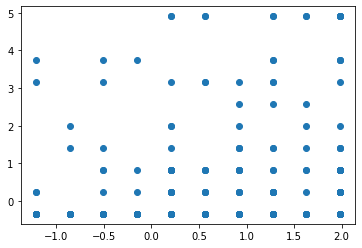

In [23]:
plt.scatter(X_Wine[:,1],X_Wine[:,-1])
plt.show()
plt.scatter(X_BC[:,1],X_BC[:,-1])
plt.show()

# Wine Quality Dataset Run

## K-Mean Clustering

In [24]:
K_Km_Wine = list(range(2,X_Wine.shape[1]))
inertia_Wine, sil_scores_Wine, homo_scores_Wine, ars_Wine,homogeneity_completeness_v_measure_Wine = execute_K(K_Km_Wine,X_Wine,Y_Wine)

In [25]:
print( len(K_Km_Wine),len(inertia_Wine))

9 9


In [26]:
print(homogeneity_completeness_v_measure_Wine[1])

(0.03437165605157221, 0.0412766810351475, 0.037509030287451194)


No handles with labels found to put in legend.


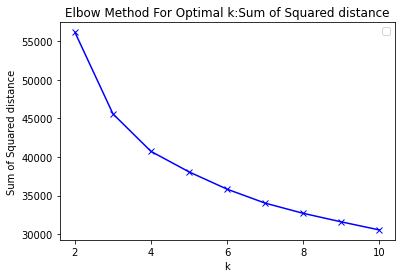

No handles with labels found to put in legend.


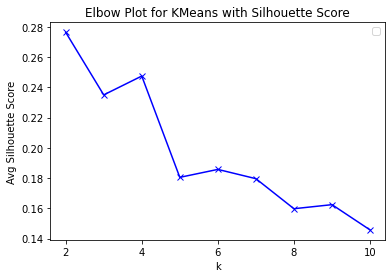

No handles with labels found to put in legend.


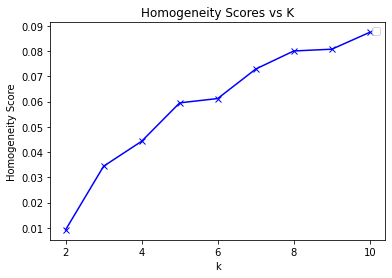

No handles with labels found to put in legend.


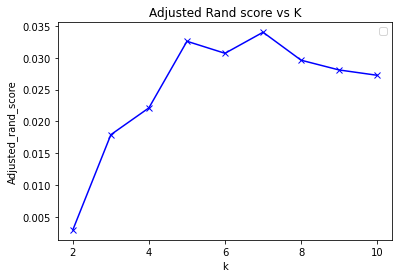

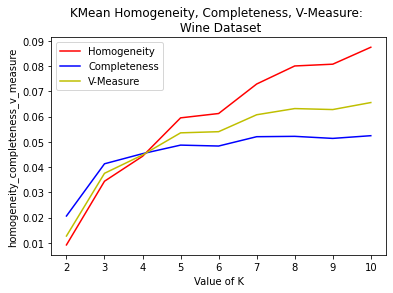

In [27]:
plot_cluster(K_Km_Wine, [inertia_Wine], 'bx-', [''], 'Elbow Method For Optimal k:Sum of Squared distance','k','Sum of Squared distance', 'K-Mean-inertia.jpg')
plot_cluster(K_Km_Wine, [sil_scores_Wine], 'bx-', [''], 'Elbow Plot for KMeans with Silhouette Score','k','Avg Silhouette Score', 'K-Mean-Silhouette.jpg')
plot_cluster(K_Km_Wine, [homo_scores_Wine], 'bx-', [''], 'Homogeneity Scores vs K','k','Homogeneity Score', 'K-Mean-Homogeneity.jpg')
plot_cluster(K_Km_Wine, [ars_Wine], 'bx-', [''], 'Adjusted Rand score vs K','k','Adjusted_rand_score', 'K-MeanARS.jpg')
plot_hcv(K_Km_Wine,homogeneity_completeness_v_measure_Wine, 'KMean Homogeneity, Completeness, V-Measure: \n Wine Dataset','K-Mean-HCV-Wine.jpg' )

## Expecatation Maximization

In [28]:
n_components_list_EM_Wine = list(range(1,X_Wine.shape[1]+1))
bic_scores_Wine, aic_scores_Wine, ll_Wine = execute_EM(n_components_list_EM_Wine, X_Wine, Y_Wine)

In [29]:
print(len(n_components_list_EM_Wine), len(bic_scores_Wine), len(aic_scores_Wine), len(ll_Wine))

11 11 11 11


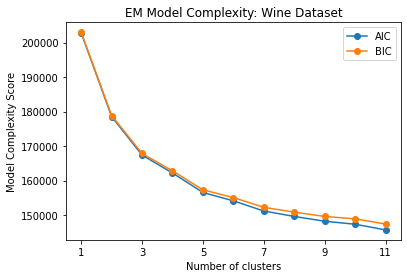

No handles with labels found to put in legend.


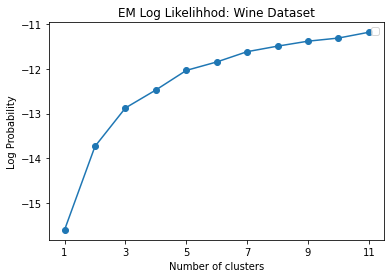

In [30]:
plot_cluster(n_components_list_EM_Wine, [aic_scores_Wine, bic_scores_Wine], 'o-', ['AIC','BIC'], 'EM Model Complexity: Wine Dataset','Number of clusters','Model Complexity Score', 'EM-aic-bic.jpg', True)
plot_cluster(n_components_list_EM_Wine, [ll_Wine], 'o-', [''], 'EM Log Likelihhod: Wine Dataset','Number of clusters','Log Probability', 'EM-aic-bic.jpg', True)


## Dimensionality Reduction Algorithms

### PCA

In [31]:
pca_Wine, cum_var_Wine = execute_PCA(X_Wine,Y_Wine)
pca_exp_var_range_Wine = list(range(len(pca_Wine.explained_variance_ratio_)))
pca_singular_values_Wine = pca_Wine.explained_variance_
pca_singular_values_range_Wine = list(range(len(pca_singular_values_Wine)))



No handles with labels found to put in legend.


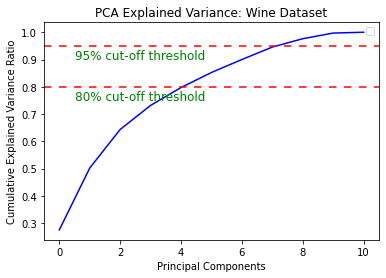

No handles with labels found to put in legend.


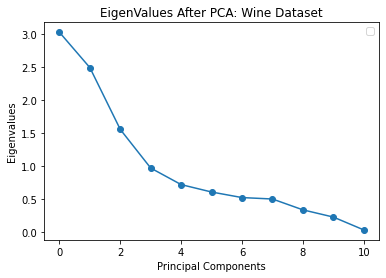

In [32]:
plot_cluster(pca_exp_var_range_Wine, [cum_var_Wine], 'b-', [''], 'PCA Explained Variance: Wine Dataset','Principal Components','Cumulative Explained Variance Ratio', 'PCA-EM-Wine.jpg',cumsum=True)
plot_cluster(pca_singular_values_range_Wine, [pca_singular_values_Wine], 'o-', [''], 'EigenValues After PCA: Wine Dataset','Principal Components','Eigenvalues', 'PCA-Eigen-Wine.jpg')


### ICA

In [34]:
# print(np.isfinite(X_Wine))
dims_ica_Wine, kurt_ica_Wine = execute_ICA(X_Wine,Y_Wine)

No handles with labels found to put in legend.


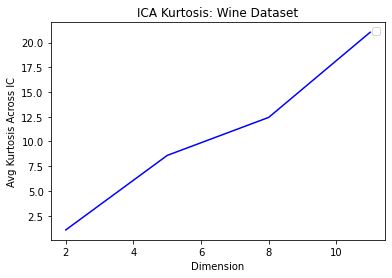

In [35]:
plot_cluster(dims_ica_Wine, [kurt_ica_Wine], 'b-', [''], 'ICA Kurtosis: Wine Dataset','Dimension','Avg Kurtosis Across IC', 'PCA-Kurtosis-Wine.jpg')


### Randomize Projection

In [36]:
dims_rca_Wine, mean_recon_rca_Wine, std_recon_Wine = execute_RP(X_Wine,Y_Wine,4)

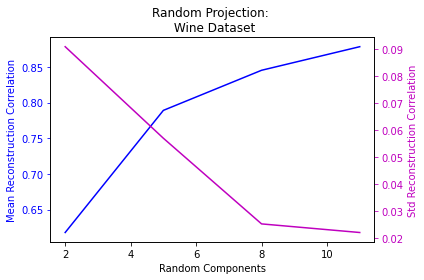

In [37]:
plot_rca(dims_rca_Wine, mean_recon_rca_Wine, std_recon_Wine, 'Random Projection: \n Wine Dataset', 'Random Components', ['Mean Reconstruction Correlation', 'Std Reconstruction Correlation'], 'RCA-Wine.jpg')

### RF

In [38]:
imp_rf_Wine, top_cols_rf_Wine = execute_RFC(X_Wine,Y_Wine,df_Wine.drop('quality', axis=1),500,5,-1)

In [39]:
print(imp_rf_Wine)
print(top_cols_rf_Wine)

                      Feature Importance   Cum Sum
alcohol                         0.337443  0.337443
volatile acidity                0.152934  0.490377
density                         0.124238  0.614615
chlorides                       0.089243  0.703858
sulphates                       0.052228  0.756086
citric acid                     0.051540  0.807626
total sulfur dioxide            0.046818  0.854444
['alcohol', 'volatile acidity', 'density', 'chlorides', 'sulphates', 'citric acid', 'total sulfur dioxide']


## Running Clusteing Experiment on K-Mean and Expetation Maximization

In [40]:
X_pca_cluster_Wine = pca_cluster(X_Wine,4,5)
X_ica_cluster_Wine = ica_cluster(X_Wine,4,5)
X_rca_cluster_Wine = rca_cluster(X_Wine,4,5)
X_rf_cluster_Wine = rf_cluster(df_Wine, 'quality', top_cols_rf_Wine)
# print(X_rf_cluster_Wine)

In [41]:
pca_cluster_inertia_Wine, pca_cluster_sil_scores_Wine, pca_cluster_homo_scores_Wine, pca_cluster_ars_Wine, pca_hcv_Wine = execute_K(K_Km_Wine,X_pca_cluster_Wine,Y_Wine)
ica_cluster_inertia_Wine, ica_cluster_sil_scores_Wine, ica_cluster_homo_scores_Wine, ica_cluster_ars_Wine, pca_hcv_Wine = execute_K(K_Km_Wine,X_ica_cluster_Wine,Y_Wine)
rca_cluster_inertia_Wine, rca_cluster_sil_scores_Wine, rca_cluster_homo_scores_Wine, rca_cluster_ars_Wine, pca_hcv_Wine = execute_K(K_Km_Wine,X_rca_cluster_Wine,Y_Wine)
rf_cluster_inertia_Wine, rf_cluster_sil_scores_Wine, rf_cluster_homo_scores_Wine, rf_cluster_ars_Wine, pca_hcv_Wine = execute_K(K_Km_Wine,X_rf_cluster_Wine,Y_Wine)

In [42]:
pca_cluster_bic_scores_Wine, pca_cluster_aic_scores_Wine, pca_cluster_ll_Wine = execute_EM(n_components_list_EM_Wine, X_pca_cluster_Wine, Y_Wine)
ica_cluster_bic_scores_Wine, ica_cluster_aic_scores_Wine, ica_cluster_ll_Wine = execute_EM(n_components_list_EM_Wine, X_ica_cluster_Wine, Y_Wine)
rca_cluster_bic_scores_Wine, rca_cluster_aic_scores_Wine, rca_cluster_ll_Wine = execute_EM(n_components_list_EM_Wine, X_rca_cluster_Wine, Y_Wine)
rf_cluster_bic_scores_Wine, rf_cluster_aic_scores_Wine, rf_cluster_ll_Wine = execute_EM(n_components_list_EM_Wine, X_rf_cluster_Wine, Y_Wine)


#### Plot PCA cluster for K mean

No handles with labels found to put in legend.


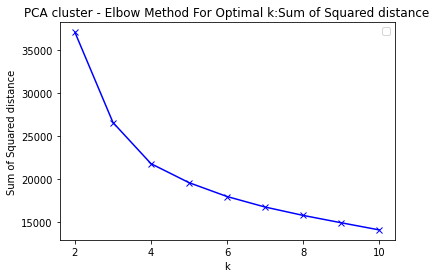

No handles with labels found to put in legend.


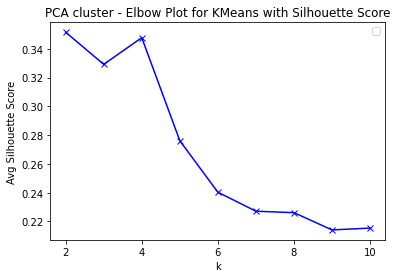

No handles with labels found to put in legend.


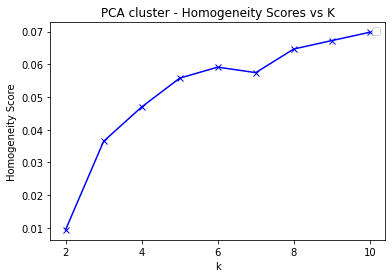

No handles with labels found to put in legend.


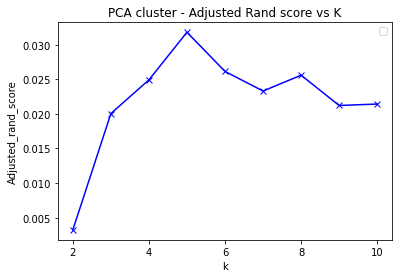

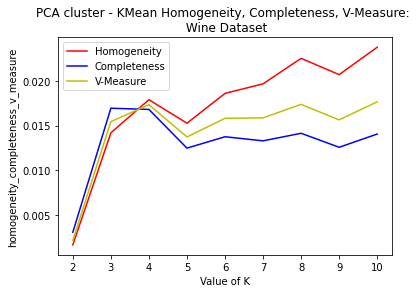

In [43]:
plot_cluster(K_Km_Wine, [pca_cluster_inertia_Wine], 'bx-', [''], 'PCA cluster - Elbow Method For Optimal k:Sum of Squared distance','k','Sum of Squared distance', 'PCA-Cluster-K-Mean-inertia.jpg')
plot_cluster(K_Km_Wine, [pca_cluster_sil_scores_Wine], 'bx-', [''], 'PCA cluster - Elbow Plot for KMeans with Silhouette Score','k','Avg Silhouette Score', 'PCA-Cluster-K-Mean-Silhouette.jpg')
plot_cluster(K_Km_Wine, [pca_cluster_homo_scores_Wine], 'bx-', [''], 'PCA cluster - Homogeneity Scores vs K','k','Homogeneity Score', 'PCA-Cluster-K-Mean-Homogeneity.jpg')
plot_cluster(K_Km_Wine, [pca_cluster_ars_Wine], 'bx-', [''], 'PCA cluster - Adjusted Rand score vs K','k','Adjusted_rand_score', 'PCA-Cluster-K-MeanARS.jpg')
plot_hcv(K_Km_Wine,pca_hcv_Wine, 'PCA cluster - KMean Homogeneity, Completeness, V-Measure: \n Wine Dataset','PCA-Cluster-K-Mean-HCV-Wine.jpg' )

#### Plot PCA cluster for Expectation Maximization

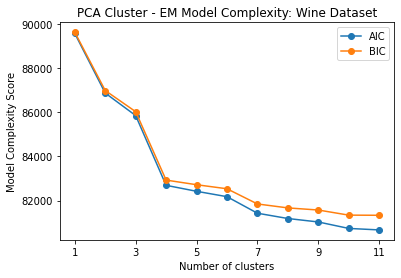

No handles with labels found to put in legend.


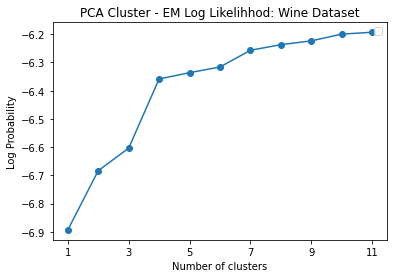

In [44]:
plot_cluster(n_components_list_EM_Wine, [pca_cluster_aic_scores_Wine, pca_cluster_bic_scores_Wine], 'o-', ['AIC','BIC'], 'PCA Cluster - EM Model Complexity: Wine Dataset','Number of clusters','Model Complexity Score', 'PCA-Cluster-EM-aic-bic.jpg', True)
plot_cluster(n_components_list_EM_Wine, [pca_cluster_ll_Wine], 'o-', [''], 'PCA Cluster - EM Log Likelihhod: Wine Dataset','Number of clusters','Log Probability', 'PCA-Cluster-EM-aic-bic.jpg')


#### Plot ICA cluster for K mean

No handles with labels found to put in legend.


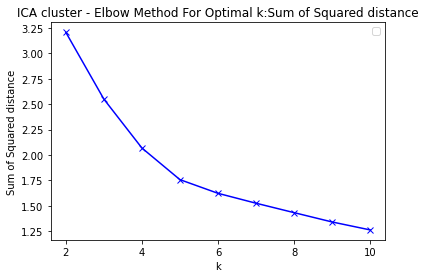

No handles with labels found to put in legend.


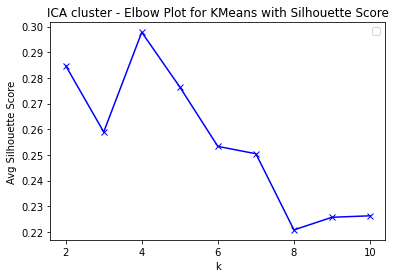

No handles with labels found to put in legend.


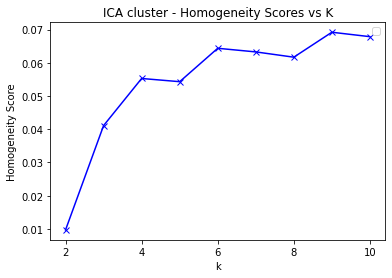

No handles with labels found to put in legend.


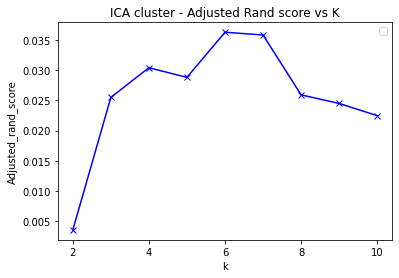

In [45]:
plot_cluster(K_Km_Wine, [ica_cluster_inertia_Wine], 'bx-', [''], 'ICA cluster - Elbow Method For Optimal k:Sum of Squared distance','k','Sum of Squared distance', 'ICA-Cluster-K-Mean-inertia.jpg')
plot_cluster(K_Km_Wine, [ica_cluster_sil_scores_Wine], 'bx-', [''], 'ICA cluster - Elbow Plot for KMeans with Silhouette Score','k','Avg Silhouette Score', 'ICA-Cluster-K-Mean-Silhouette.jpg')
plot_cluster(K_Km_Wine, [ica_cluster_homo_scores_Wine], 'bx-', [''], 'ICA cluster - Homogeneity Scores vs K','k','Homogeneity Score', 'ICA-Cluster-K-Mean-Homogeneity.jpg')
plot_cluster(K_Km_Wine, [ica_cluster_ars_Wine], 'bx-', [''], 'ICA cluster - Adjusted Rand score vs K','k','Adjusted_rand_score', 'ICA-Cluster-K-MeanARS.jpg')

#### Plot ICA cluster for Expectation Maximization

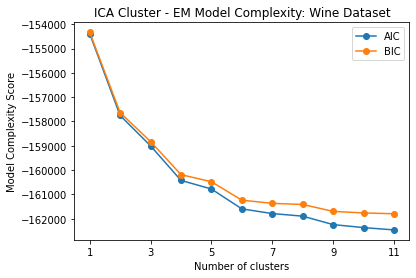

No handles with labels found to put in legend.


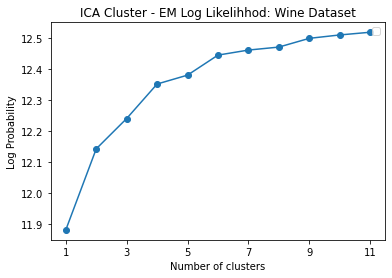

In [46]:
plot_cluster(n_components_list_EM_Wine, [ica_cluster_aic_scores_Wine, ica_cluster_bic_scores_Wine], 'o-', ['AIC','BIC'], 'ICA Cluster - EM Model Complexity: Wine Dataset','Number of clusters','Model Complexity Score', 'ICA-Cluster-EM-aic-bic.jpg', True)
plot_cluster(n_components_list_EM_Wine, [ica_cluster_ll_Wine], 'o-', [''], 'ICA Cluster - EM Log Likelihhod: Wine Dataset','Number of clusters','Log Probability', 'ICA-Cluster-EM-aic-bic.jpg')


#### Plot RCA cluster for K mean

No handles with labels found to put in legend.


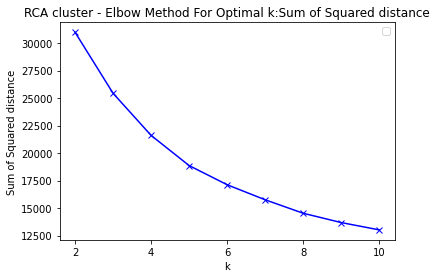

No handles with labels found to put in legend.


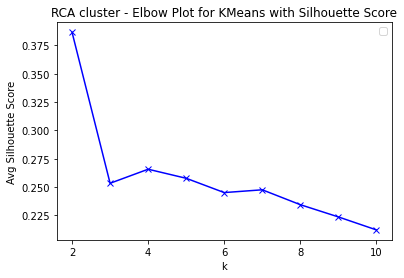

No handles with labels found to put in legend.


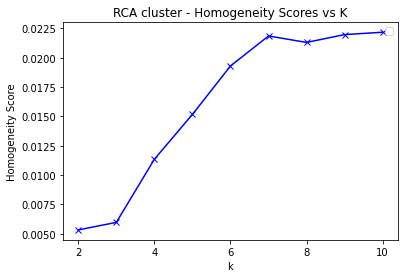

No handles with labels found to put in legend.


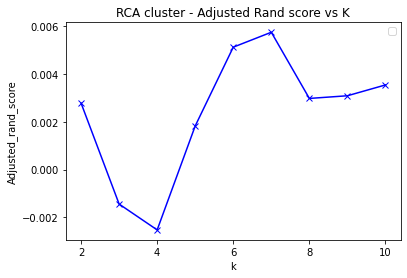

In [47]:
plot_cluster(K_Km_Wine, [rca_cluster_inertia_Wine], 'bx-', [''], 'RCA cluster - Elbow Method For Optimal k:Sum of Squared distance','k','Sum of Squared distance', 'RCA-Cluster-K-Mean-inertia.jpg')
plot_cluster(K_Km_Wine, [rca_cluster_sil_scores_Wine], 'bx-', [''], 'RCA cluster - Elbow Plot for KMeans with Silhouette Score','k','Avg Silhouette Score', 'RCA-Cluster-K-Mean-Silhouette.jpg')
plot_cluster(K_Km_Wine, [rca_cluster_homo_scores_Wine], 'bx-', [''], 'RCA cluster - Homogeneity Scores vs K','k','Homogeneity Score', 'RCA-Cluster-K-Mean-Homogeneity.jpg')
plot_cluster(K_Km_Wine, [rca_cluster_ars_Wine], 'bx-', [''], 'RCA cluster - Adjusted Rand score vs K','k','Adjusted_rand_score', 'RCA-Cluster-K-MeanARS.jpg')

#### Plot RCA cluster for Expectation Maximization

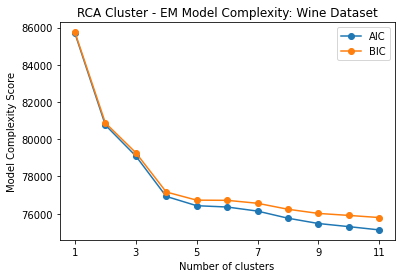

No handles with labels found to put in legend.


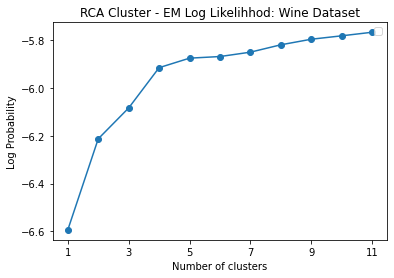

In [48]:
plot_cluster(n_components_list_EM_Wine, [rca_cluster_aic_scores_Wine, rca_cluster_bic_scores_Wine], 'o-', ['AIC','BIC'], 'RCA Cluster - EM Model Complexity: Wine Dataset','Number of clusters','Model Complexity Score', 'RCA-Cluster-EM-aic-bic.jpg', True)
plot_cluster(n_components_list_EM_Wine, [rca_cluster_ll_Wine], 'o-', [''], 'RCA Cluster - EM Log Likelihhod: Wine Dataset','Number of clusters','Log Probability', 'RCA-Cluster-EM-aic-bic.jpg')


#### Plot RF cluster for K mean

No handles with labels found to put in legend.


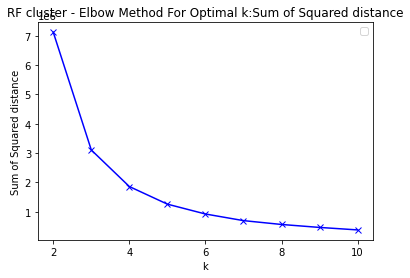

No handles with labels found to put in legend.


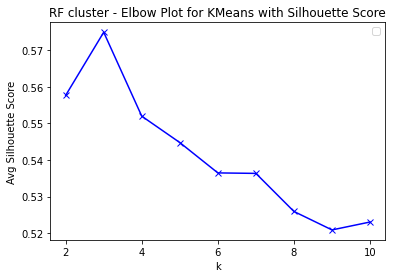

No handles with labels found to put in legend.


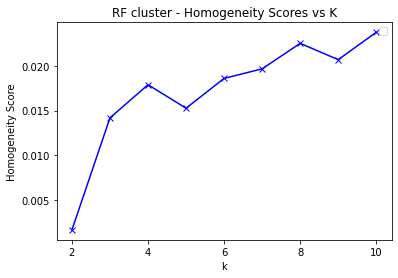

No handles with labels found to put in legend.


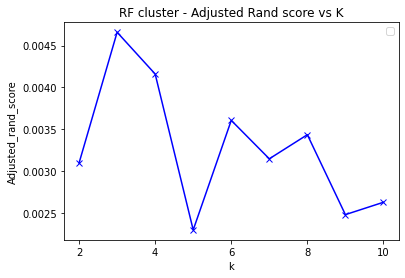

In [49]:
plot_cluster(K_Km_Wine, [rf_cluster_inertia_Wine], 'bx-', [''], 'RF cluster - Elbow Method For Optimal k:Sum of Squared distance','k','Sum of Squared distance', 'RF-Cluster-K-Mean-inertia.jpg')
plot_cluster(K_Km_Wine, [rf_cluster_sil_scores_Wine], 'bx-', [''], 'RF cluster - Elbow Plot for KMeans with Silhouette Score','k','Avg Silhouette Score', 'RF-Cluster-K-Mean-Silhouette.jpg')
plot_cluster(K_Km_Wine, [rf_cluster_homo_scores_Wine], 'bx-', [''], 'RF cluster - Homogeneity Scores vs K','k','Homogeneity Score', 'RF-Cluster-K-Mean-Homogeneity.jpg')
plot_cluster(K_Km_Wine, [rf_cluster_ars_Wine], 'bx-', [''], 'RF cluster - Adjusted Rand score vs K','k','Adjusted_rand_score', 'RF-Cluster-K-MeanARS.jpg')

#### Plot RF cluster for Expectation Maximization

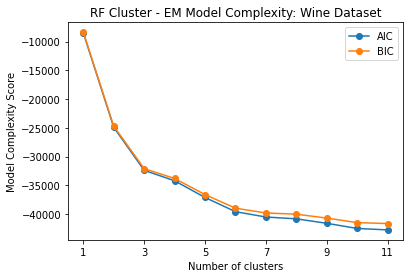

No handles with labels found to put in legend.


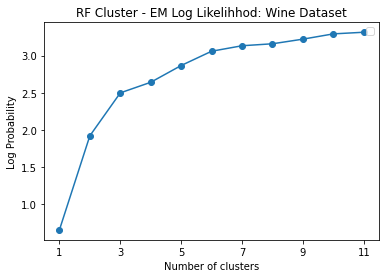

In [50]:
plot_cluster(n_components_list_EM_Wine, [rf_cluster_aic_scores_Wine, rf_cluster_bic_scores_Wine], 'o-', ['AIC','BIC'], 'RF Cluster - EM Model Complexity: Wine Dataset','Number of clusters','Model Complexity Score', 'RF-Cluster-EM-aic-bic.jpg', True)
plot_cluster(n_components_list_EM_Wine, [rf_cluster_ll_Wine], 'o-', [''], 'RF Cluster - EM Log Likelihhod: Wine Dataset','Number of clusters','Log Probability', 'RF-Cluster-EM-aic-bic.jpg')


## Compositition Analysis

### PCA

In [51]:
reduced_data_pca_Wine = PCA(n_components=2).fit_transform(X_Wine)
reduced_data_pca_Wine, Z_Value_pca_Wine, kmeans_pca_Wine, xx_pca_wine, yy_pca_Wine, x_min_pca_Wine, x_max_pca_Wine, y_min_pca_Wine, y_max_pca_Wine = composition_analysis(reduced_data_pca_Wine, X_Wine,Y_Wine,10,cluster=4)

#### Plot composition data for PCA

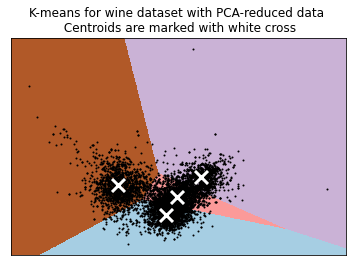

In [52]:
plot_composition(reduced_data_pca_Wine, Z_Value_pca_Wine, kmeans_pca_Wine, xx_pca_wine, yy_pca_Wine, x_min_pca_Wine, x_max_pca_Wine, y_min_pca_Wine, y_max_pca_Wine, 'K-means for wine dataset with PCA-reduced data \n Centroids are marked with white cross', 'PCA-CA-Wine.jpg')

### ICA

In [53]:
reduced_data_ica_Wine = FastICA(n_components = 2, random_state= seed).fit_transform(X_Wine)
reduced_data_ica_Wine, Z_Value_ica_Wine, kmeans_ica_Wine, xx_ica_wine, yy_ica_Wine, x_min_ica_Wine, x_max_ica_Wine, y_min_ica_Wine, y_max_ica_Wine = composition_analysis(reduced_data_ica_Wine, X_Wine,Y_Wine,10,cluster=4)

#### Plot composition data for ICA

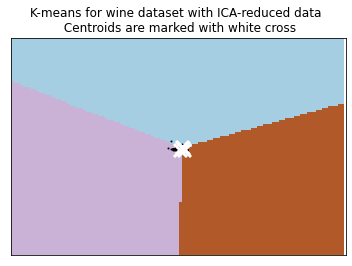

In [54]:
plot_composition(reduced_data_ica_Wine, Z_Value_ica_Wine, kmeans_ica_Wine, xx_ica_wine, yy_ica_Wine, x_min_ica_Wine, x_max_ica_Wine, y_min_ica_Wine, y_max_ica_Wine, 'K-means for wine dataset with ICA-reduced data \n Centroids are marked with white cross', 'ICA-CA-Wine.jpg')

### RCA

In [55]:
reduced_data_rca_Wine = RCA(n_components =2, random_state= seed).fit_transform(X_Wine)
reduced_data_rca_Wine, Z_Value_rca_Wine, kmeans_rca_Wine, xx_rca_wine, yy_rca_Wine, x_min_rca_Wine, x_max_rca_Wine, y_min_rca_Wine, y_max_rca_Wine = composition_analysis(reduced_data_rca_Wine, X_Wine,Y_Wine,10,cluster=4)

#### Plot composition data for RCA

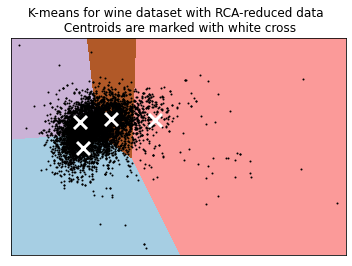

In [56]:
plot_composition(reduced_data_rca_Wine, Z_Value_rca_Wine, kmeans_rca_Wine, xx_rca_wine, yy_rca_Wine,x_min_rca_Wine, x_max_rca_Wine, y_min_rca_Wine, y_max_rca_Wine, 'K-means for wine dataset with RCA-reduced data \n Centroids are marked with white cross', 'RCA-CA-Wine.jpg')

### RF

In [57]:
reduced_data_rf_Wine = df_Wine[top_cols_rf_Wine[:2]].to_numpy()
reduced_data_rf_Wine, Z_Value_rf_Wine, kmeans_rf_Wine, xx_rf_wine, yy_rf_Wine, x_min_rf_Wine, x_max_rf_Wine, y_min_rf_Wine, y_max_rf_Wine = composition_analysis(reduced_data_rf_Wine, X_Wine,Y_Wine,10,cluster=4)

#### Plot composition data for RF

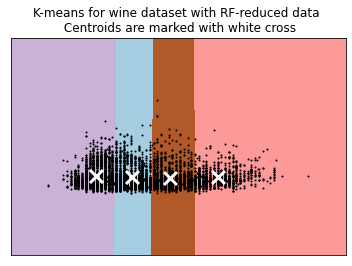

In [58]:
plot_composition(reduced_data_rf_Wine, Z_Value_rf_Wine, kmeans_rf_Wine, xx_rf_wine, yy_rf_Wine, x_min_rf_Wine, x_max_rf_Wine, y_min_rf_Wine, y_max_rf_Wine, 'K-means for wine dataset with RF-reduced data \n Centroids are marked with white cross', 'RF-CA-Wine.jpg')

# Breast Cancer Dataset Run

## K-Mean Clustering

In [59]:
K_Km_BC = list(range(2,X_BC.shape[1]))
inertia_BC, sil_scores_BC, homo_scores_BC, ars_BC,hcv_BC = execute_K(K_Km_BC,X_BC,Y_BC)

In [60]:
print( len(K_Km_BC),len(inertia_BC))

8 8


No handles with labels found to put in legend.


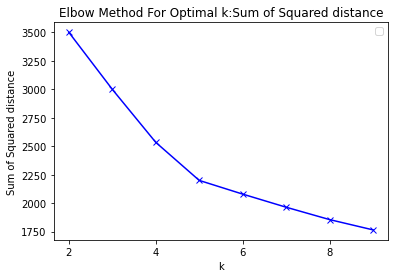

No handles with labels found to put in legend.


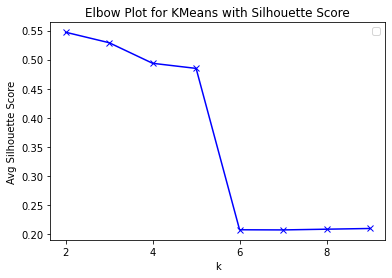

No handles with labels found to put in legend.


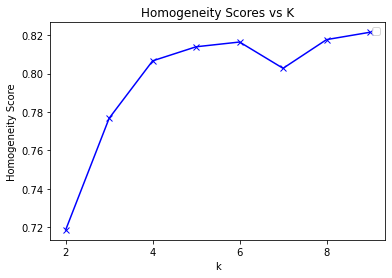

No handles with labels found to put in legend.


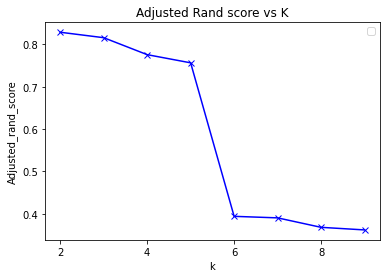

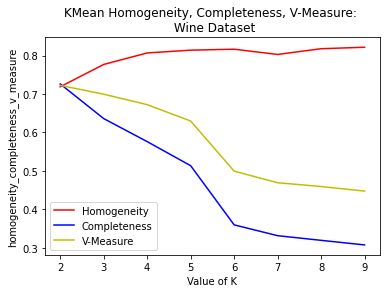

In [61]:
plot_cluster(K_Km_BC, [inertia_BC], 'bx-', [''], 'Elbow Method For Optimal k:Sum of Squared distance','k','Sum of Squared distance', 'K-Mean-inertia.jpg')
plot_cluster(K_Km_BC, [sil_scores_BC], 'bx-', [''], 'Elbow Plot for KMeans with Silhouette Score','k','Avg Silhouette Score', 'K-Mean-Silhouette.jpg')
plot_cluster(K_Km_BC, [homo_scores_BC], 'bx-', [''], 'Homogeneity Scores vs K','k','Homogeneity Score', 'K-Mean-Homogeneity.jpg')
plot_cluster(K_Km_BC, [ars_BC], 'bx-', [''], 'Adjusted Rand score vs K','k','Adjusted_rand_score', 'K-MeanARS.jpg')
plot_hcv(K_Km_BC,hcv_BC, 'KMean Homogeneity, Completeness, V-Measure: \n Wine Dataset','K-Mean-HCV-Wine.jpg' )

## Expecatation Maximization

In [62]:
n_components_list_EM_BC = list(range(1,X_BC.shape[1]+1))
bic_scores_BC, aic_scores_BC, ll_BC = execute_EM(n_components_list_EM_BC, X_BC, Y_BC)

In [63]:
print(len(n_components_list_EM_BC), len(bic_scores_BC), len(aic_scores_BC), len(ll_BC))

10 10 10 10


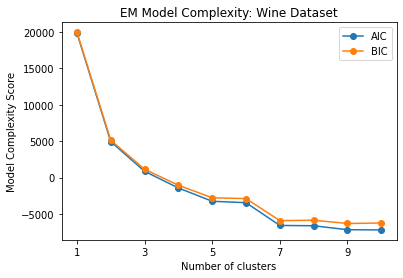

No handles with labels found to put in legend.


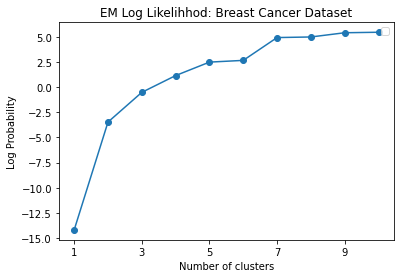

In [64]:
plot_cluster(n_components_list_EM_BC, [aic_scores_BC, bic_scores_BC], 'o-', ['AIC','BIC'], 'EM Model Complexity: Wine Dataset','Number of clusters','Model Complexity Score', 'EM-aic-bic.jpg', True)
plot_cluster(n_components_list_EM_BC, [ll_BC], 'o-', [''], 'EM Log Likelihhod: Breast Cancer Dataset','Number of clusters','Log Probability', 'EM-aic-bic.jpg', True)


## Dimensionality Reduction Algorithms

### PCA

In [65]:
pca_BC, cum_var_BC = execute_PCA(X_BC,Y_BC)
pca_exp_var_range_BC = list(range(len(pca_BC.explained_variance_ratio_)))
pca_singular_values_BC = pca_BC.explained_variance_
pca_singular_values_range_BC = list(range(len(pca_singular_values_BC)))



No handles with labels found to put in legend.


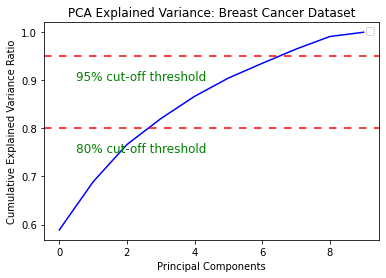

No handles with labels found to put in legend.


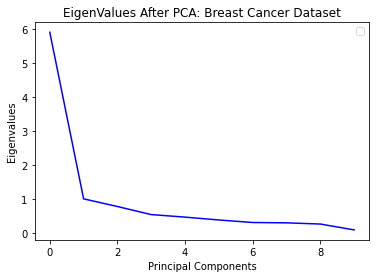

In [66]:
plot_cluster(pca_exp_var_range_BC, [cum_var_BC], 'b-', [''], 'PCA Explained Variance: Breast Cancer Dataset','Principal Components','Cumulative Explained Variance Ratio', 'PCA-EM-Breast Cancer.jpg',cumsum=True)
plot_cluster(pca_singular_values_range_BC, [pca_singular_values_BC], 'b-', [''], 'EigenValues After PCA: Breast Cancer Dataset','Principal Components','Eigenvalues', 'PCA-Eigen-Breast Cancer.jpg')


### ICA

In [68]:
dims_ica_BC, kurt_ica_BC = execute_ICA(X_BC,Y_BC)

No handles with labels found to put in legend.


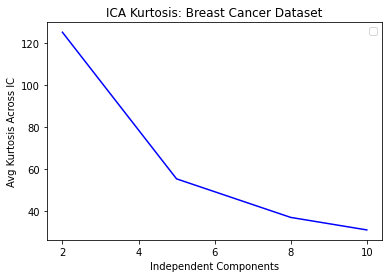

In [69]:
plot_cluster(dims_ica_BC, [kurt_ica_BC], 'b-', [''], 'ICA Kurtosis: Breast Cancer Dataset','Independent Components','Avg Kurtosis Across IC', 'PCA-Kurtosis-Breast Cancer.jpg')


### Randomize Projection

In [70]:
dims_rca_BC, mean_recon_rca_BC, std_recon_BC = execute_RP(X_BC,Y_BC,5)

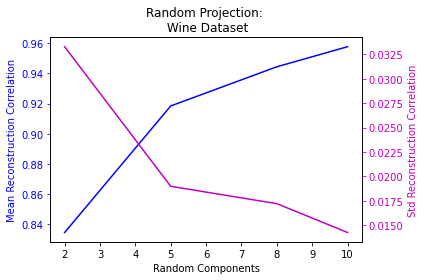

In [71]:
plot_rca(dims_rca_BC, mean_recon_rca_BC, std_recon_BC, 'Random Projection: \n Wine Dataset', 'Random Components', ['Mean Reconstruction Correlation', 'Std Reconstruction Correlation'], 'RCA-Breast Cancer.jpg')

### RF

In [72]:
imp_rf_BC, top_cols_rf_BC = execute_RFC(X_BC,Y_BC,df_BC.drop('Class', axis=1),500,5,-1)

In [73]:
print(imp_rf_BC)
print(top_cols_rf_BC)

                             Feature Importance   Cum Sum
Uniformity of Cell Size                0.257282  0.257282
Uniformity of Cell Shape               0.218144  0.475426
Bare Nuclei                            0.154339  0.629765
Bland Chromatin                        0.145214  0.774979
Single Epithelial Cell Size            0.069372  0.844351
['Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Bare Nuclei', 'Bland Chromatin', 'Single Epithelial Cell Size']


## Running Clusteing Experiment on K-Mean and Expetation Maximization

In [74]:
X_pca_cluster_BC = pca_cluster(X_BC,6,5)
X_ica_cluster_BC = ica_cluster(X_BC,12,5)
X_rca_cluster_BC = rca_cluster(X_BC,8,5)
X_rf_cluster_BC = rf_cluster(df_BC, 'Class', top_cols_rf_BC)

In [75]:
pca_cluster_inertia_BC, pca_cluster_sil_scores_BC, pca_cluster_homo_scores_BC, pca_cluster_ars_BC, pca_hcv_BC = execute_K(K_Km_BC,X_pca_cluster_BC,Y_BC)
ica_cluster_inertia_BC, ica_cluster_sil_scores_BC, ica_cluster_homo_scores_BC, ica_cluster_ars_BC, pca_hcv_BC = execute_K(K_Km_BC,X_ica_cluster_BC,Y_BC)
rca_cluster_inertia_BC, rca_cluster_sil_scores_BC, rca_cluster_homo_scores_BC, rca_cluster_ars_BC, pca_hcv_BC = execute_K(K_Km_BC,X_rca_cluster_BC,Y_BC)
rf_cluster_inertia_BC, rf_cluster_sil_scores_BC, rf_cluster_homo_scores_BC, rf_cluster_ars_BC, pca_hcv_BC = execute_K(K_Km_BC,X_rf_cluster_BC,Y_BC)

In [76]:
pca_cluster_bic_scores_BC, pca_cluster_aic_scores_BC, pca_cluster_ll_BC = execute_EM(n_components_list_EM_BC, X_pca_cluster_BC, Y_BC)
ica_cluster_bic_scores_BC, ica_cluster_aic_scores_BC, ica_cluster_ll_BC = execute_EM(n_components_list_EM_BC, X_ica_cluster_BC, Y_BC)
rca_cluster_bic_scores_BC, rca_cluster_aic_scores_BC, rca_cluster_ll_BC = execute_EM(n_components_list_EM_BC, X_rca_cluster_BC, Y_BC)
rf_cluster_bic_scores_BC, rf_cluster_aic_scores_BC, rf_cluster_ll_BC = execute_EM(n_components_list_EM_BC, X_rf_cluster_BC, Y_BC)

#### Plot PCA cluster for K mean

No handles with labels found to put in legend.


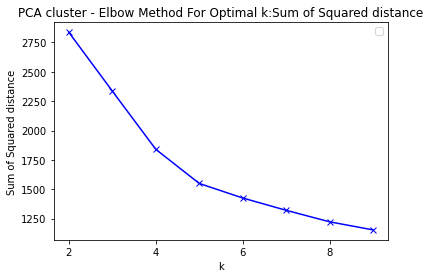

No handles with labels found to put in legend.


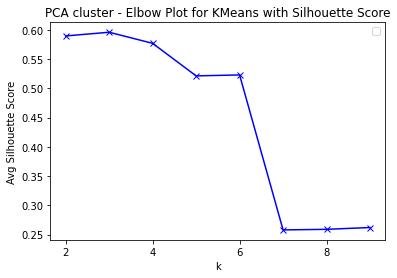

No handles with labels found to put in legend.


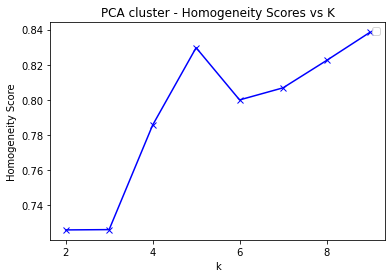

No handles with labels found to put in legend.


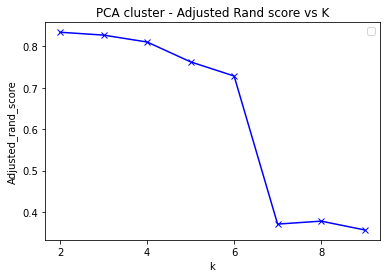

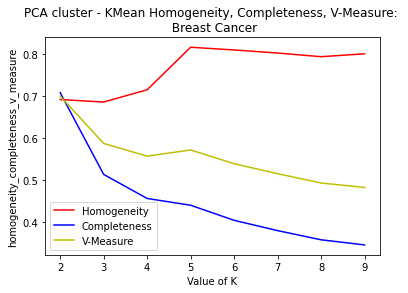

In [77]:
plot_cluster(K_Km_BC, [pca_cluster_inertia_BC], 'bx-', [''], 'PCA cluster - Elbow Method For Optimal k:Sum of Squared distance','k','Sum of Squared distance', 'PCA-Cluster-K-Mean-inertia.jpg')
plot_cluster(K_Km_BC, [pca_cluster_sil_scores_BC], 'bx-', [''], 'PCA cluster - Elbow Plot for KMeans with Silhouette Score','k','Avg Silhouette Score', 'PCA-Cluster-K-Mean-Silhouette.jpg')
plot_cluster(K_Km_BC, [pca_cluster_homo_scores_BC], 'bx-', [''], 'PCA cluster - Homogeneity Scores vs K','k','Homogeneity Score', 'PCA-Cluster-K-Mean-Homogeneity.jpg')
plot_cluster(K_Km_BC, [pca_cluster_ars_BC], 'bx-', [''], 'PCA cluster - Adjusted Rand score vs K','k','Adjusted_rand_score', 'PCA-Cluster-K-MeanARS.jpg')
plot_hcv(K_Km_BC,pca_hcv_BC, 'PCA cluster - KMean Homogeneity, Completeness, V-Measure: \n Breast Cancer','PCA-Cluster-K-Mean-HCV-BC.jpg' )

#### Plot PCA cluster for Expectation Maximization

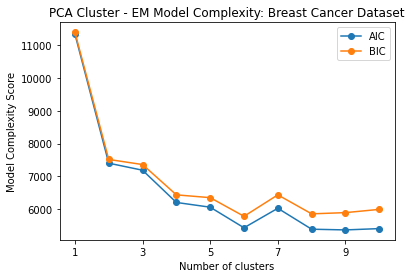

No handles with labels found to put in legend.


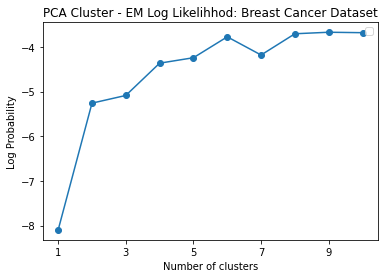

In [78]:
plot_cluster(n_components_list_EM_BC, [pca_cluster_aic_scores_BC, pca_cluster_bic_scores_BC], 'o-', ['AIC','BIC'], 'PCA Cluster - EM Model Complexity: Breast Cancer Dataset','Number of clusters','Model Complexity Score', 'PCA-Cluster-EM-aic-bic.jpg', True)
plot_cluster(n_components_list_EM_BC, [pca_cluster_ll_BC], 'o-', [''], 'PCA Cluster - EM Log Likelihhod: Breast Cancer Dataset','Number of clusters','Log Probability', 'PCA-Cluster-EM-aic-bic.jpg')


#### Plot ICA cluster for K mean

No handles with labels found to put in legend.


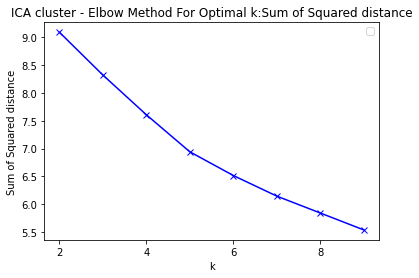

No handles with labels found to put in legend.


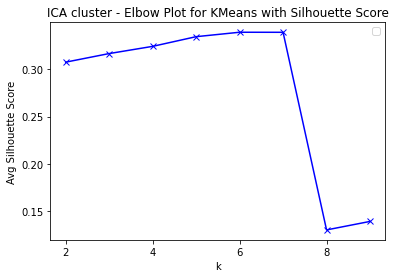

No handles with labels found to put in legend.


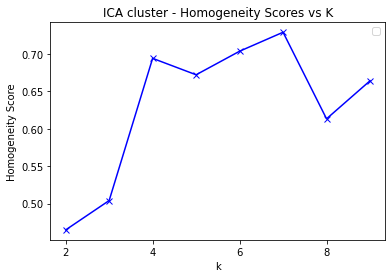

No handles with labels found to put in legend.


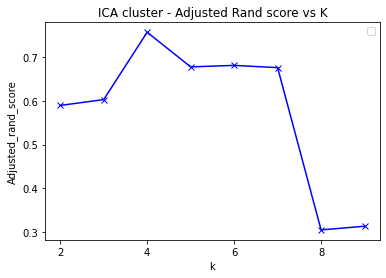

In [79]:
plot_cluster(K_Km_BC, [ica_cluster_inertia_BC], 'bx-', [''], 'ICA cluster - Elbow Method For Optimal k:Sum of Squared distance','k','Sum of Squared distance', 'ICA-Cluster-K-Mean-inertia.jpg')
plot_cluster(K_Km_BC, [ica_cluster_sil_scores_BC], 'bx-', [''], 'ICA cluster - Elbow Plot for KMeans with Silhouette Score','k','Avg Silhouette Score', 'ICA-Cluster-K-Mean-Silhouette.jpg')
plot_cluster(K_Km_BC, [ica_cluster_homo_scores_BC], 'bx-', [''], 'ICA cluster - Homogeneity Scores vs K','k','Homogeneity Score', 'ICA-Cluster-K-Mean-Homogeneity.jpg')
plot_cluster(K_Km_BC, [ica_cluster_ars_BC], 'bx-', [''], 'ICA cluster - Adjusted Rand score vs K','k','Adjusted_rand_score', 'ICA-Cluster-K-MeanARS.jpg')

#### Plot ICA cluster for Expectation Maximization

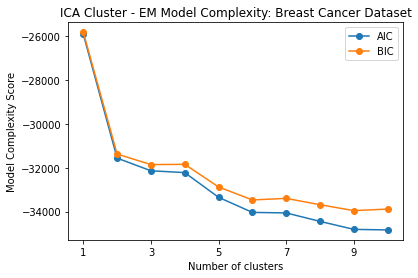

No handles with labels found to put in legend.


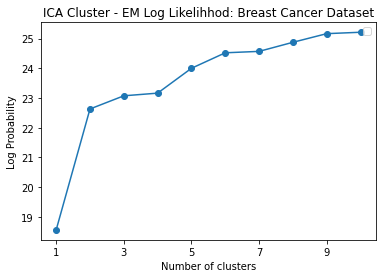

In [80]:
plot_cluster(n_components_list_EM_BC, [ica_cluster_aic_scores_BC, ica_cluster_bic_scores_BC], 'o-', ['AIC','BIC'], 'ICA Cluster - EM Model Complexity: Breast Cancer Dataset','Number of clusters','Model Complexity Score', 'ICA-Cluster-EM-aic-bic.jpg', True)
plot_cluster(n_components_list_EM_BC, [ica_cluster_ll_BC], 'o-', [''], 'ICA Cluster - EM Log Likelihhod: Breast Cancer Dataset','Number of clusters','Log Probability', 'ICA-Cluster-EM-aic-bic.jpg')


#### Plot RCA cluster for K mean

No handles with labels found to put in legend.


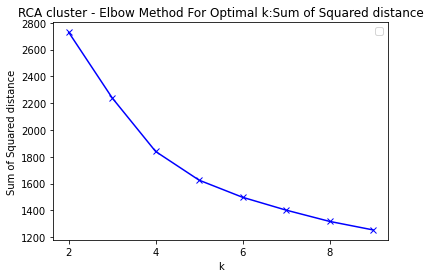

No handles with labels found to put in legend.


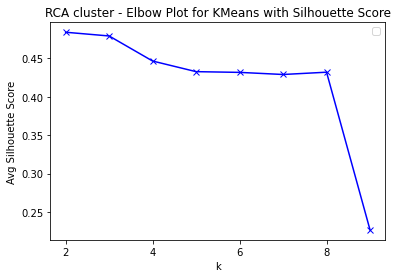

No handles with labels found to put in legend.


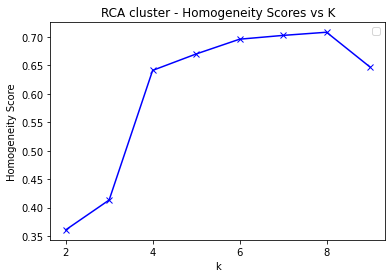

No handles with labels found to put in legend.


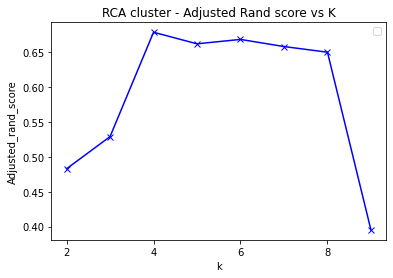

In [81]:
plot_cluster(K_Km_BC, [rca_cluster_inertia_BC], 'bx-', [''], 'RCA cluster - Elbow Method For Optimal k:Sum of Squared distance','k','Sum of Squared distance', 'RCA-Cluster-K-Mean-inertia.jpg')
plot_cluster(K_Km_BC, [rca_cluster_sil_scores_BC], 'bx-', [''], 'RCA cluster - Elbow Plot for KMeans with Silhouette Score','k','Avg Silhouette Score', 'RCA-Cluster-K-Mean-Silhouette.jpg')
plot_cluster(K_Km_BC, [rca_cluster_homo_scores_BC], 'bx-', [''], 'RCA cluster - Homogeneity Scores vs K','k','Homogeneity Score', 'RCA-Cluster-K-Mean-Homogeneity.jpg')
plot_cluster(K_Km_BC, [rca_cluster_ars_BC], 'bx-', [''], 'RCA cluster - Adjusted Rand score vs K','k','Adjusted_rand_score', 'RCA-Cluster-K-MeanARS.jpg')

#### Plot RCA cluster for Expectation Maximization

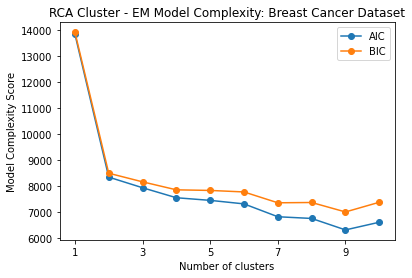

No handles with labels found to put in legend.


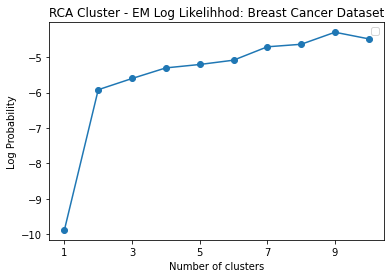

In [82]:
plot_cluster(n_components_list_EM_BC, [rca_cluster_aic_scores_BC, rca_cluster_bic_scores_BC], 'o-', ['AIC','BIC'], 'RCA Cluster - EM Model Complexity: Breast Cancer Dataset','Number of clusters','Model Complexity Score', 'RCA-Cluster-EM-aic-bic.jpg', True)
plot_cluster(n_components_list_EM_BC, [rca_cluster_ll_BC], 'o-', [''], 'RCA Cluster - EM Log Likelihhod: Breast Cancer Dataset','Number of clusters','Log Probability', 'RCA-Cluster-EM-aic-bic.jpg')


#### Plot RF cluster for K mean

No handles with labels found to put in legend.


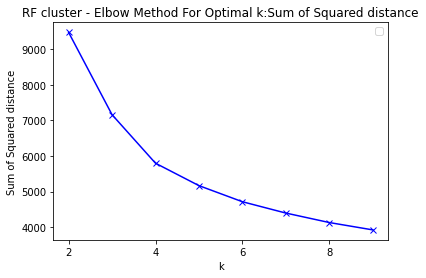

No handles with labels found to put in legend.


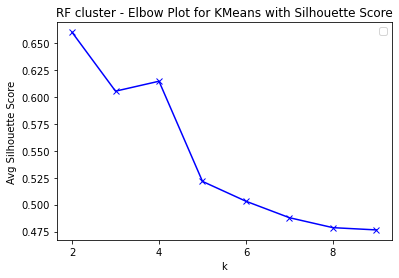

No handles with labels found to put in legend.


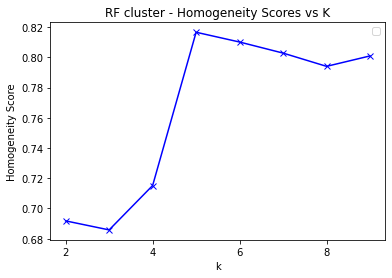

No handles with labels found to put in legend.


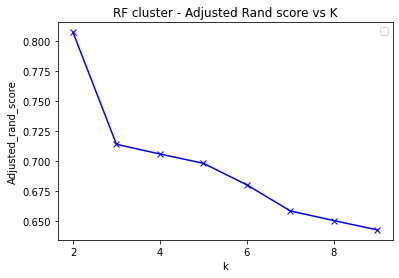

In [83]:
plot_cluster(K_Km_BC, [rf_cluster_inertia_BC], 'bx-', [''], 'RF cluster - Elbow Method For Optimal k:Sum of Squared distance','k','Sum of Squared distance', 'RF-Cluster-K-Mean-inertia.jpg')
plot_cluster(K_Km_BC, [rf_cluster_sil_scores_BC], 'bx-', [''], 'RF cluster - Elbow Plot for KMeans with Silhouette Score','k','Avg Silhouette Score', 'RF-Cluster-K-Mean-Silhouette.jpg')
plot_cluster(K_Km_BC, [rf_cluster_homo_scores_BC], 'bx-', [''], 'RF cluster - Homogeneity Scores vs K','k','Homogeneity Score', 'RF-Cluster-K-Mean-Homogeneity.jpg')
plot_cluster(K_Km_BC, [rf_cluster_ars_BC], 'bx-', [''], 'RF cluster - Adjusted Rand score vs K','k','Adjusted_rand_score', 'RF-Cluster-K-MeanARS.jpg')

#### Plot RF cluster for Expectation Maximization

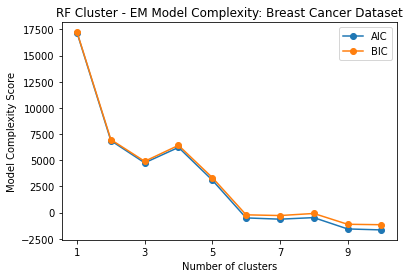

No handles with labels found to put in legend.


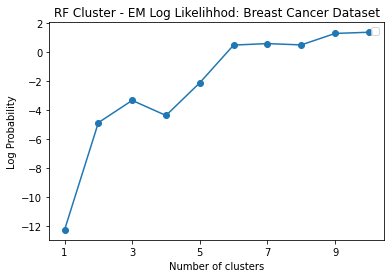

In [84]:
plot_cluster(n_components_list_EM_BC, [rf_cluster_aic_scores_BC, rf_cluster_bic_scores_BC], 'o-', ['AIC','BIC'], 'RF Cluster - EM Model Complexity: Breast Cancer Dataset','Number of clusters','Model Complexity Score', 'RF-Cluster-EM-aic-bic.jpg', True)
plot_cluster(n_components_list_EM_BC, [rf_cluster_ll_BC], 'o-', [''], 'RF Cluster - EM Log Likelihhod: Breast Cancer Dataset','Number of clusters','Log Probability', 'RF-Cluster-EM-aic-bic.jpg')


## Compositition Analysis

### PCA

In [85]:
reduced_data_pca_BC = PCA(n_components=2).fit_transform(X_BC)
reduced_data_pca_BC, Z_Value_pca_BC, kmeans_pca_BC, xx_pca_BC, yy_pca_BC, x_min_pca_BC, x_max_pca_BC, y_min_pca_BC, y_max_pca_BC = composition_analysis(reduced_data_pca_BC, X_BC,Y_BC,10,cluster=5)

#### Plot composition data for PCA

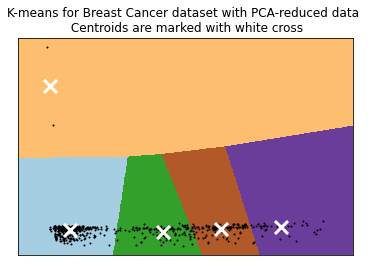

In [86]:
plot_composition(reduced_data_pca_BC, Z_Value_pca_BC, kmeans_pca_BC, xx_pca_BC, yy_pca_BC, x_min_pca_BC, x_max_pca_BC, y_min_pca_BC, y_max_pca_BC, 'K-means for Breast Cancer dataset with PCA-reduced data \n Centroids are marked with white cross', 'PCA-CA-Breast Cancer.jpg')

### ICA

In [87]:
reduced_data_ica_BC = FastICA(n_components = 2, random_state= seed).fit_transform(X_BC)
reduced_data_ica_BC, Z_Value_ica_BC, kmeans_ica_BC, xx_ica_BC, yy_ica_BC, x_min_ica_BC, x_max_ica_BC, y_min_ica_BC, y_max_ica_BC = composition_analysis(reduced_data_ica_BC, X_BC,Y_BC,10,cluster=5)

#### Plot composition data for ICA

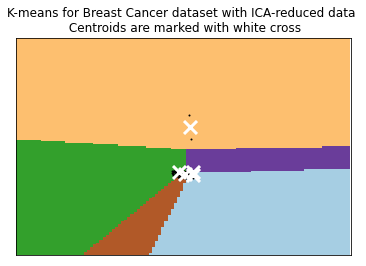

In [88]:
plot_composition(reduced_data_ica_BC, Z_Value_ica_BC, kmeans_ica_BC, xx_ica_BC, yy_ica_BC, x_min_ica_BC, x_max_ica_BC, y_min_ica_BC, y_max_ica_BC, 'K-means for Breast Cancer dataset with ICA-reduced data \n Centroids are marked with white cross', 'ICA-CA-Breast Cancer.jpg')

### RCA

In [89]:
reduced_data_rca_BC = RCA(n_components =2, random_state= seed).fit_transform(X_BC)
reduced_data_rca_BC, Z_Value_rca_BC, kmeans_rca_BC, xx_rca_BC, yy_rca_BC, x_min_rca_BC, x_max_rca_BC, y_min_rca_BC, y_max_rca_BC = composition_analysis(reduced_data_rca_BC, X_BC,Y_BC,10,cluster=5)

#### Plot composition data for RCA

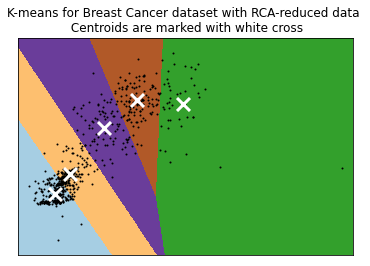

In [90]:
plot_composition(reduced_data_rca_BC, Z_Value_rca_BC, kmeans_rca_BC, xx_rca_BC, yy_rca_BC,x_min_rca_BC, x_max_rca_BC, y_min_rca_BC, y_max_rca_BC, 'K-means for Breast Cancer dataset with RCA-reduced data \n Centroids are marked with white cross', 'RCA-CA-Breast Cancer.jpg')

### RF

In [91]:
reduced_data_rf_BC = df_BC[top_cols_rf_BC[:2]].to_numpy()
reduced_data_rf_BC, Z_Value_rf_BC, kmeans_rf_BC, xx_rf_BC, yy_rf_BC, x_min_rf_BC, x_max_rf_BC, y_min_rf_BC, y_max_rf_BC = composition_analysis(reduced_data_rf_BC, X_BC,Y_BC,10,cluster=5)

#### Plot composition data for RF

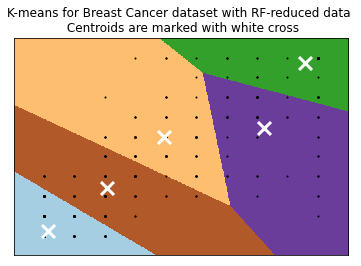

In [92]:
plot_composition(reduced_data_rf_BC, Z_Value_rf_BC, kmeans_rf_BC, xx_rf_BC, yy_rf_BC, x_min_rf_BC, x_max_rf_BC, y_min_rf_BC, y_max_rf_BC, 'K-means for Breast Cancer dataset with RF-reduced data \n Centroids are marked with white cross', 'RF-CA-Breast Cancer.jpg')